# 모듈 임포트

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
import pandas as pd

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.
런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

# 데이터 적재 (train_X->dict, train_y->dict)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_X_case = {}

for i in range(1, 29):
    train_X_case["{}".format(str(i).zfill(2))] =\
      pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/train_input/CASE_{}.csv".format(str(i).zfill(2)))
 

In [5]:
train_y_case = {}

for i in range(1, 29):
    train_y_case["{}".format(str(i).zfill(2))] =\
      pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/train_target/CASE_{}.csv".format(str(i).zfill(2)))
 

In [14]:
train_X_case["01"].head(3)

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,0,01:00,25.680357,81.264286,528.696429,1.409003,126.0,126.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2,0,02:00,25.273333,81.471666,532.833333,1.406913,0.0,126.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0


In [7]:
train_y_case["01"].head(3)

,DAT,predicted_weight_g
0,1,0.167719
1,2,0.181787
2,3,0.265921


 28개의 상추를 28일 동안 24시간 간격으로 측정한 데이터이다.

 28 * 24 = 672

 - feature는 16개
 - train_y는 매일 측정된 상추의 잎 크기이다.

 잎의 성장은 전날의 데이터에 영향을 받는다. (청경채 예측 분석 코드공유를 참고함.)

 각 상추의 train_X를 28개로 나눈 뒤, 하루 뒤의 train_y를 예측하게 할 것이다.

 https://dacon.io/competitions/official/235961/overview/description

상추의 생육환경 예측과 비슷한 문제인 청경채 성장 경진대회를 많이 참고할 예정이다.

# 데이터 전처리

- 데이터셋 나누기 
    1. 28개의 상추를 하루 단위씩 끊어서 데이터셋을 새로 만들기
    2. 하루단위 데이터를 평균낸 데이터를 다시 합쳐서 데이터셋을 새로 만들기

- target 데이터 전처리
    1. 전날 대비 성장률 추가 
    2. 초기 대비 성장률 추가

- null 값 처리

- 컬럼별 상관관계 보기

- 이상치 처리

- target 데이터 가공
    1. 있는 그대로 사용
    2. 처음과 비교했을 때 얼마나 성장 했는지 계산해서 사용

### 데이터셋 나누기

In [80]:
# train_X_case_day[x][y] 를 입력하면 x 케이스의 y번째 날 데이터 프레임을 리턴함
train_X_case_day = [[]]

for i in range(1,29):
    train_X_case_day.append([])
    for j in range(1,29):
        train_X_case_day[i].append(train_X_case["{}".format(str(i).zfill(2))].iloc[24*(j-1):j*24, :])

### 타겟데이터 전처리
test_y를 건드릴 수는 없다.

In [9]:
for case in range(1,29):
    CASE = str(case).zfill(2)
    IGR = []                    # 초기 대비 성장률(initial growth rate): IGR
    DOD = []                    # 전날 대비 성장률(day over day growth rate): DOD
    for day in range(1, 28):
        id = train_y_case[CASE].iloc[0, 1]          # inital day
        yd = train_y_case[CASE].iloc[(day-1),1]     # yester day
        td = train_y_case[CASE].iloc[day, 1]        # today

        IGR.append((td-id)/id*100)
        DOD.append((td-yd)/yd*100)

    IGR.append(0)
    DOD.append(0)

    train_y_case[CASE]["초기 대비 성장률(%)"] = IGR
    train_y_case[CASE]["전날 대비 성장률(%)"] = DOD

In [10]:
train_y_case["01"].head(3)

,DAT,predicted_weight_g,초기 대비 성장률(%),전날 대비 성장률(%)
0,1,0.167719,8.387751,8.387751
1,2,0.181787,58.551144,46.281423
2,3,0.265921,152.594543,59.314235


### 상관관계 보기

In [17]:
plt.rcParams['font.family'] = 'NanumGothic'

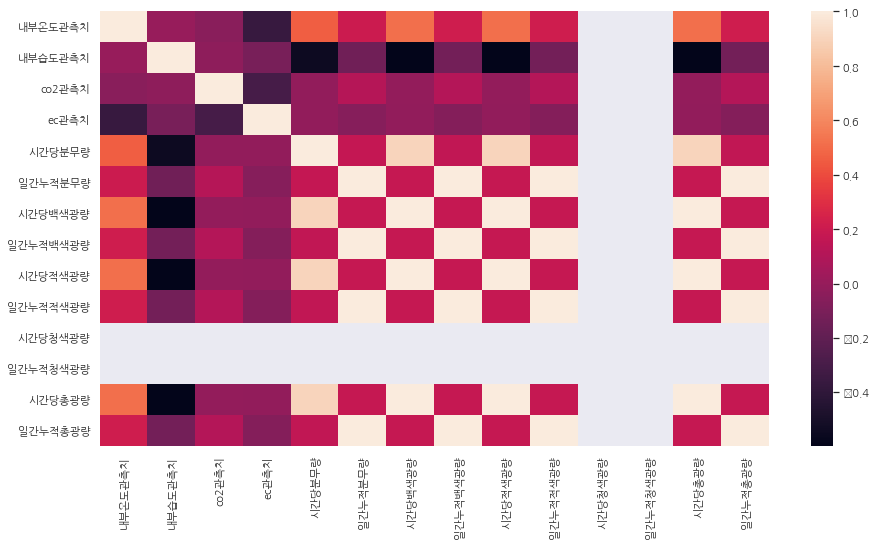

In [19]:
sns.set(font="NanumGothic",
        rc = {'figure.figsize':(15,8)})

sns.heatmap(train_X_case["01"].drop((["DAT", "obs_time"]), axis=1).corr())

상관관계에서 뭔가를 얻지는 못했다. 

상관관계 표에 아예 색칠되지 않은 부분은 통제변인으로써 작용하는 듯 하다.

### null 값 처리

null 값이 없다.

In [40]:
for i in range(1, 29):
    CASE = str(i).zfill(2)
    for _ in train_X_case[CASE].isnull().sum():
        if _ == True:
            print(_)

### 이상치 처리

- 시간당 내부 평균온도: 4도~40도
- 시간당 내부 평균습도: 0% ~ 100%
- 시간당 내부 평균 co2 농도 : 0ppm ~ 1200 ppm
- 시간당 평균 EC : 0 ~ 8
- 시간당 분무량 : 0 ~ 3000 / 일간 누적 분무량 0 ~ 72,000
- 시간당 백색광량 : 0 ~ 120,000 / 일간 누적 백색광량 0 ~ 2,880,000
- 시간당 적색광량 : 0 ~ 120,000 / 일간 누적 적색광량 0 ~ 2,880,000 
- 시간당 청색광량 : 0 ~ 120,000 / 일간 누적 청색광량 0 ~ 2,880,000
- 시간당 총광량 : 0 ~ 120,000 / 일간 누적 총광량 0 ~ 2,880,000




In [102]:
col = train_X_case["01"].columns
col

Index(['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량'],
      dtype='object')

#### 노이즈 값 처리

In [135]:
control_variable = pd.DataFrame()

noise = [[]]

for i in range(1, 29):
    noise.append([])
    CASE = str(i).zfill(2)

    # 내부 온도 관측치 
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[2]]<4].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[2]]>40].index)   

    # 내부습도 관측치
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[3]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[3]]>100].index)   

    # co2 관측치
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[4]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[4]]>1200].index)   

    # ec 관측치
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[5]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[5]]>8].index)   

    # 시간당 분무량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[6]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[6]]>3000].index)   

    # 누적 분무량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[7]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[7]]>72000].index)   

    # 시간당 백색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[8]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[8]]>120000].index)   

    # 일간 누적 백색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[9]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[9]]> 2880000].index)   

    # 시간당 적색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[10]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[10]]>120000].index)   

    # 일간 누적 적색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[11]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[11]]>2880000].index)   

    # 시간당 청색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[12]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[12]]>120000].index)   

    # 일간 누적 청색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[13]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[13]]>2880000].index)   

    # 시간당 총광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[14]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[14]]>120000].index)   

    # 일간 누적 총광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[15]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[15]]>2880000].index)   

    # # 중복값 제거
    # noise[i] = list(set(noise[i]))

In [176]:
for i in range(1, 29):
    for j in range(28):
        if len(noise[i][j]) != 0:
            print("case{} {}".format(i, col[j//2+2]))
            print(noise[i][j], "\n")

case1 co2관측치
Int64Index([639, 640, 641, 642], dtype='int64') 

case3 co2관측치
Int64Index([ 12,  15,  16,  17,  18,  19,  20,  36,  39,  40,  41,  42,  43,
             44,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 159, 160,
            161, 162, 180, 181, 182, 183, 184, 185, 186, 187, 188, 204, 205,
            206, 207, 208, 209, 210, 211, 212, 229, 230, 231, 232, 233, 234,
            235, 236, 237, 252, 253, 254, 255, 256, 257, 258, 259, 260, 325,
            326, 327, 328, 329, 330, 331, 332, 333, 334, 350, 351, 352, 353,
            354, 355, 356, 395, 396, 397, 400, 401, 402, 403, 404, 662, 663,
            664, 665, 666, 667, 668],
           dtype='int64') 

case4 내부온도관측치
Int64Index([15], dtype='int64') 

case4 co2관측치
Int64Index([549], dtype='int64') 

case6 시간당백색광량
Int64Index([15], dtype='int64') 

case6 시간당적색광량
Int64Index([15], dtype='int64') 

case6 시간당청색광량
Int64Index([15], dtype='int64') 

case6 시간당총광량
Int64Index([15], dtype='int64') 

case8 내부온도관측치
Int64Index([135, 1

일단 값이 틀린 칼럼과 인덱스는 찾았으니, 대입할 값은 나중에 처리해보자.